## Studying Bias Variance Tradeoff

We will experiment with a toy regression problem, in which we generate synthetic data (from a known p(x,y)), creating data sets of varying sizes. For each size $N$, we repeat $m$ times the following experiment: 

* draw a data set $(X,y)$ of size $N$
* fit a model (with a given degree $d$ of polynomial fit, and $\lambda$ parameter of ridge regression

Once we are done, we can plot the $m$ models as well as their average; this gives us a visual illustration of the behavior of a particular model family (defined by $d$ and $\lambda$) on data of given size.

We can also analyze the different components that contribute to the (expected, test-time) loss of these models. That's the main contribution you will have to make to the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0}) # to supress an annoying warning about too many figures

### Definitions for out data generator and related functions

In [2]:
# some utility functions provided by us

def degexpand(X, deg, C=None):
    """
    Prepares data matrix with a column of ones and polynomials of specified
    degree.

    Parameters
    ----------
        X : 2D array
            n x d data matrix (row per example)
        deg : integer
            Degree of polynomial
        C : 1D array
            Scaling weights. If not specifed, weights are calculated to fit each
            columns of X in [-1, 1].
            Note: It is shown in problem set 1 that this normalization does
            not affect linear regression, as long as it is applied
            consistently to training *and* test data.

    Returns
    -------
        out_X : 2D array
            n x (2 * d + 1) data matrix (row per example)
            The output is arranged as follows:
            <see solutions for PS1>
        C : 1D array
            Scaling weights that were used. Can be used in scaling other data later in the same way.
    """
    assert X.ndim == 2
    n, m = X.shape
    # Make polynomials
    out_X = (X[..., np.newaxis] ** (1. + np.arange(deg))).reshape(n, -1)

    # Add column of ones
    out_X = np.concatenate([np.ones((out_X.shape[0], 1)), out_X], axis=1)

    if C is None:
        C = abs(out_X).max(axis=0)
    else:
        assert np.shape(C) == (out_X.shape[1],), "C must match outgoing matrix"

    out_X /= C # divide dimension-wise
    return out_X, C


def gen_samples(fn, domain=(-5,5),num_samples=3, sigma=1.0):
    """
    Main building block for the data generator
    Produce num_samples from p(x,y) where
    x ~ uniform(domain), y|x~fn(x)+nu,  nu~N(0,sigma)
    
    Returns 2D array of shape (num_samples,2)
    """
    low, high = domain

    # sample points
    data = []
    for _ in range(num_samples):
        _input = random.uniform(low, high)
        data.append( [_input, fn(_input)] )
    data = np.array(data)

    # sample some guassian noise
    noise = np.random.normal(loc=0.0, scale=sigma, size=num_samples)
    
    data[:,1] += noise
    
    return data

def gen_train_data(fn, num_samples=3, num_sets=30, domain=(-5,5), sigma=1.0):
    """
    Generate num_sets datasets, each with num_samples points, drawn i.i.d. from
    p(x,y) defined by domain, fn, sigma (see comment for gen_samples)
    
    Returns data of shape (num_sets,num_samples,2) where (:,:,0) are xs and (:,:,1) are ys
    """

    data = np.array([gen_samples(
        fn, num_samples=num_samples, domain=domain, sigma=sigma) for _ in range(num_sets)])
    return data

def gen_val_data(fn, num_samples=100, num_sets=30,domain=(-5,5), sigma=1.0):
    """
    Generate validation data with num_samples drawn i.i.d. from p(x,y)
    where x~uniform(domain), y|x ~ fn(x)+nu, nu~N(0,sigma)
    
    This generates a set of sets, similar to gen_train_data, but for val, we get the same X
    in all the sets, but different ys (varying according to the non-deterministic model component)
    Since we want this property, the code is a bit different from gen_train_data
    """
    
    low, high = domain

    data=np.zeros([num_sets,num_samples,2])
    
    np.random.seed(789123) # fix random number generator seed for consistency; e
                           # very time you run this you should get same val set
                        
    
    # sample values of x (once)
    xs = np.random.uniform(low,high,num_samples)
    Fx = fn(xs) # the deterministic portion of y (shared by all num_sets val sets)
    
    for s in range(num_sets):
        # add random noise (different for each instance in each set)
        noise = np.random.normal(loc=0.0, scale=sigma, size=num_samples)
        data[s,:,:]=np.stack((xs,Fx+noise),axis=1)
    
    # rerandomize. Comment out for deterministic run
    from datetime import datetime
    np.random.seed(int(round(datetime.now().timestamp())))
    
    return data
    

### Solving the problem using closed form solution to ridge regreesion

In [3]:
def closed_form_reg_solution(train, lamb, degree): 
    """
    Closed form solution for ridge regression, for a givem regularization parameter 'lamb' and polynomial
    model degree 'degree'
    Expects a set of training sets, and returns a corresponding set of models
    train is of shape (M,N,2) where train(m,:,0) and train(m,:,1) are xs and ys of the m-th set

    Fit (train) a model for each set, and return a list of models. Each model is a dictionary:
    'w' -> the model parameters w
    'C' -> the feature scaling coefficients (applied to phi(x) before fitting or deploying the model)
    'deg' -> the polynomial degree (complexity) of the model
    'lambda' -> the regularization parameter for ridge regression
    """
    
    models=[]
    
    for train_data in train:
        # extract x,y from train_data
        x, y = train_data[:,:-1], train_data[:,1].reshape(-1,1)
    
        # map x to (normalized) feature maps
        x, C = degexpand(x, degree)
 
        N, m = x.shape

        I = np.eye(m)
        tmp = np.dot(x.T, x)
        tmp += lamb * I
        
        w = np.linalg.pinv(tmp).dot(x.T).dot(y)
        # numerically stable alternative courtesy of https://stackoverflow.com/a/54772323/6416660
        # w = np.linalg.solve(tmp, x.T.dot(y))

        # record the model
        models.append({'w': w, 'C': C, 'deg': degree, 'lambda': lamb})
        
    return models


### Visualization code

In [4]:
def plot(data, models, domain=(-5,5),ax=None):
    """
    Plot the data set (1D x->y) as blue dots, and the function predicted by each model in the list 'models' 
    as a red line (all the models are used, yielding a "bundle" of lines)
    The average prediction (averaged over the models for every x) is plotted as a cyan line
    """
    
    if ax is None:
        ax=plt.axes()
    
    # sample points along x to interpolate
    x_range = np.linspace(domain[0], domain[-1], 100)
    x_range = x_range.reshape(-1,1)
    mean_y = np.zeros(x_range.shape)
    
    for m in models:
        x_values, _ = degexpand(x_range, m['deg'], m['C'])
        yhat=np.dot(x_values,m['w'])
        mean_y = mean_y+yhat/len(models)
        ax.plot(x_range, yhat, 'r-', linewidth = 1,alpha=.3)
    if data is not None:
        ax.plot(data[:,0], data[:,1], 'b.',markersize=2)
    ax.plot(x_range,mean_y,'-',c='xkcd:cyan',linewidth=3)
    ax.grid(True)
    ax.set_ylim(-13,5.5)
    ax.set_title("lambda=%.2f" % (m['lambda']))
#     plt.savefig(name+"samp_my_fig")


In [5]:
# function we want to model
fn = lambda x: -0.02*x**4 + 0.1*x**3 + 0.3*x**2 - 1.2*x
# this is an example of Python's "lambda expression" which sort of defines an unnamed function. 
# Try playing with the coefficients, or maybe add terms, to get differently shaped functions
    
# the domain of the function we're sampling from
domain=(-5,5)

# std of the guassian noise to be added
sigma = 0.5

# we will explore these regularization parameters
lambdas = [0,1.0,50.0]
# and these Ns
Ns = [5,10,25,50,100]

# generate a val set (will be shared in all the experiments)
# make it large to get a meaningful approximation for the test loss
val = gen_val_data(fn, num_sets=1000, num_samples=1000, domain=domain, sigma=sigma)


### Model fitting (running the experiment)

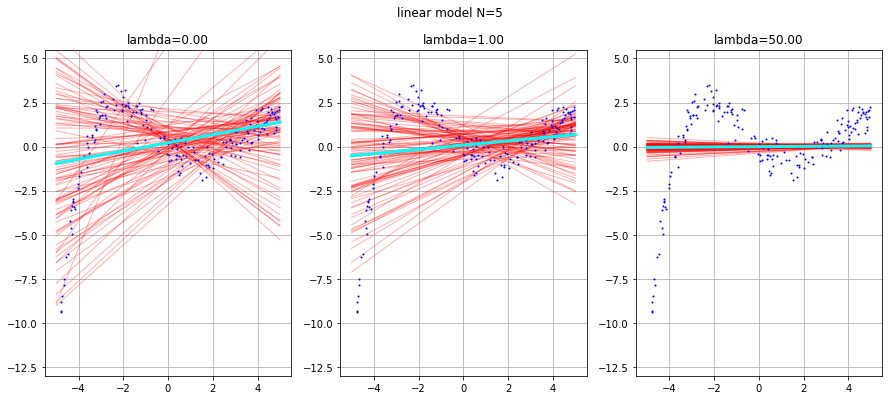

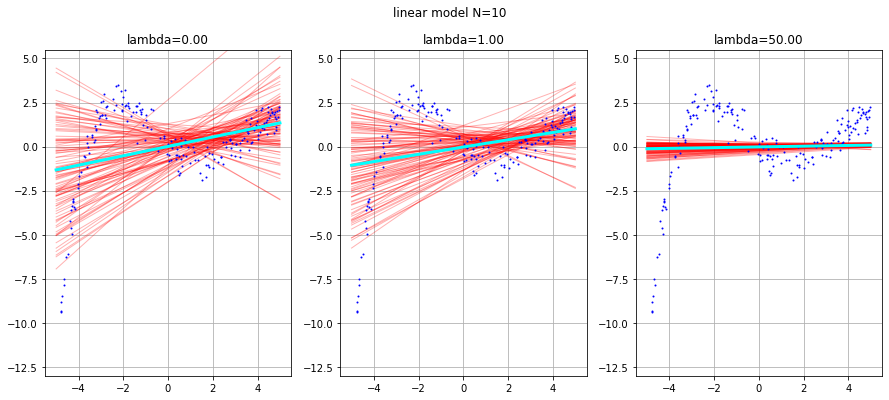

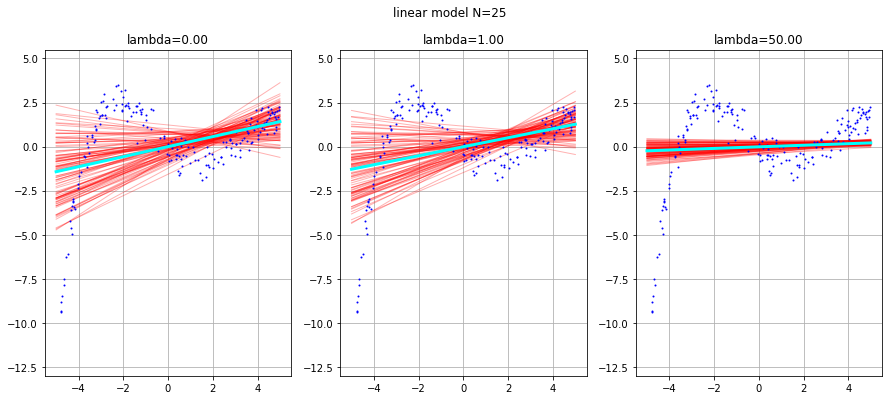

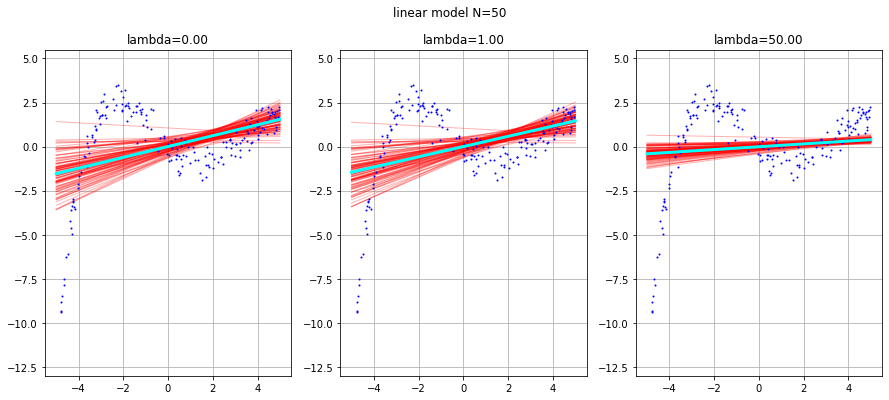

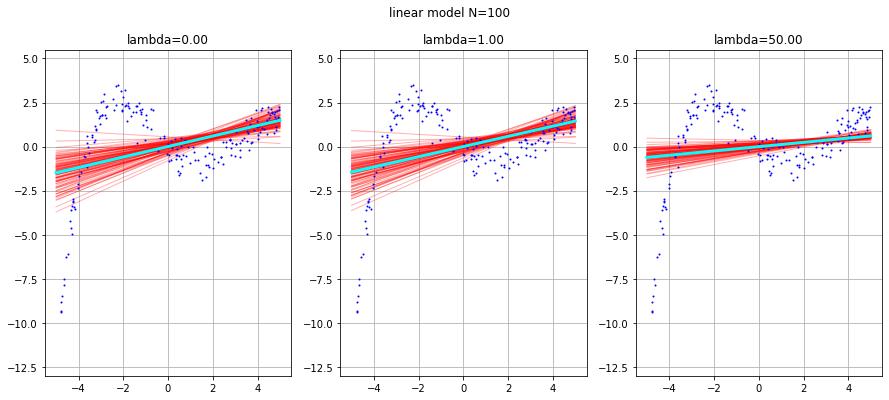

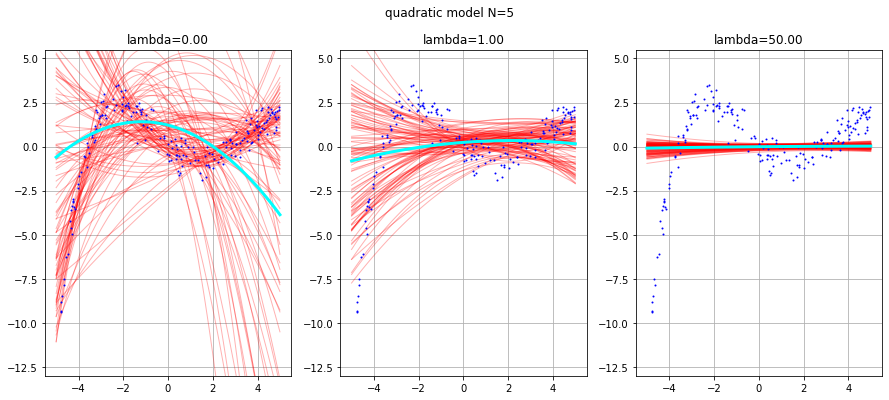

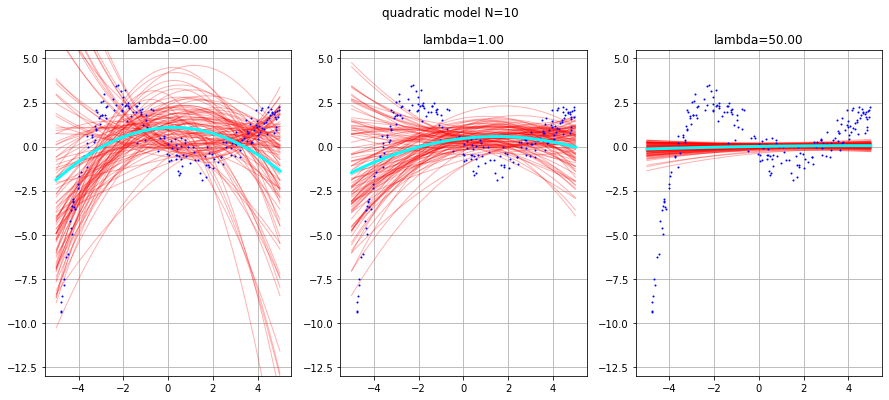

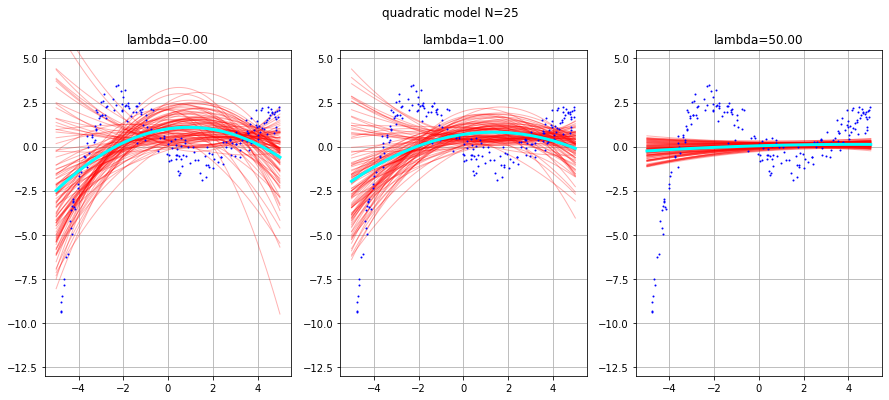

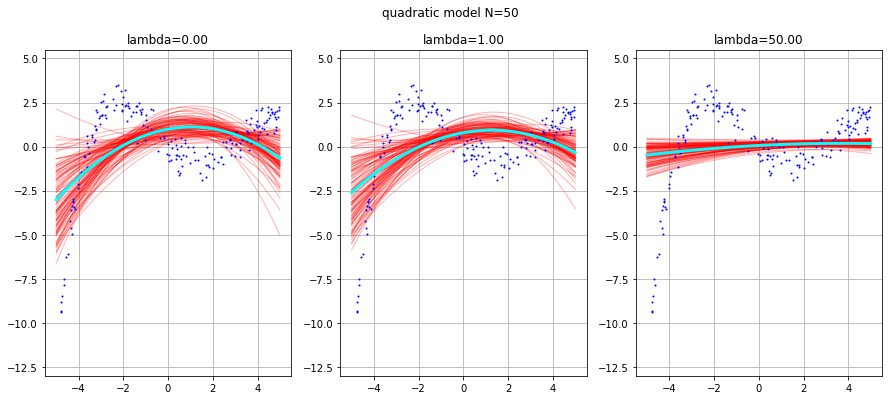

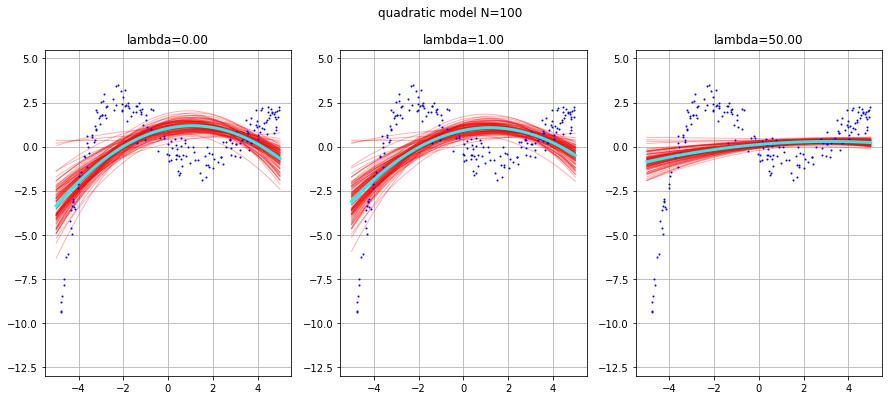

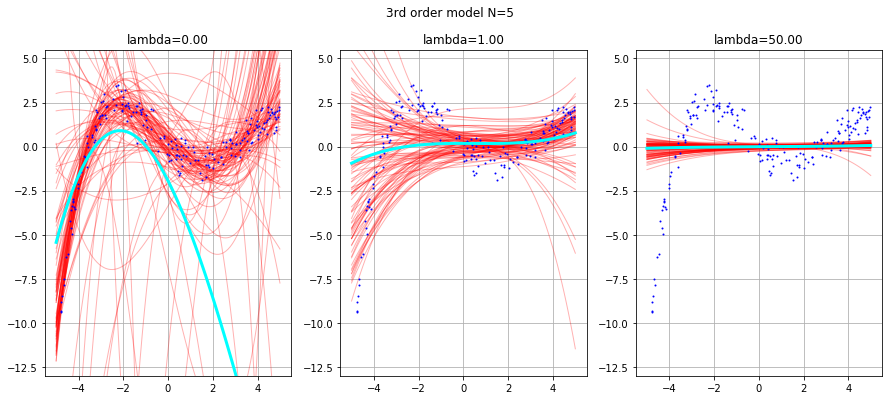

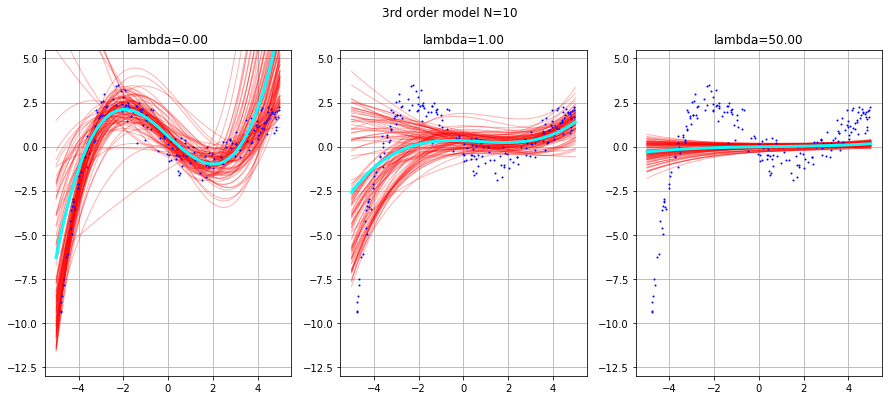

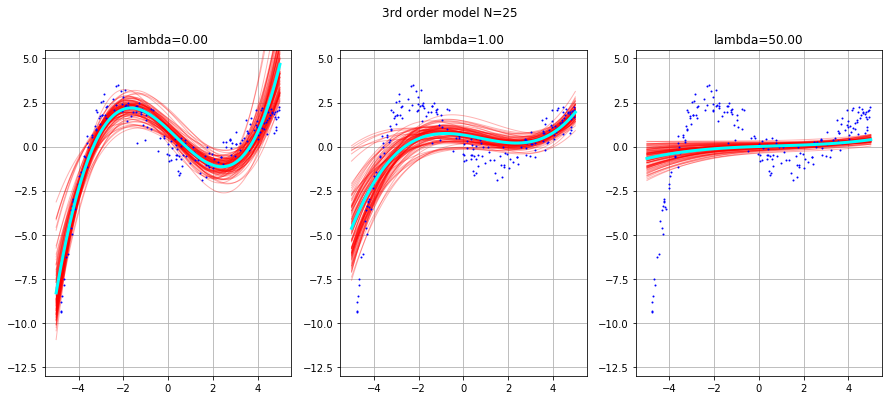

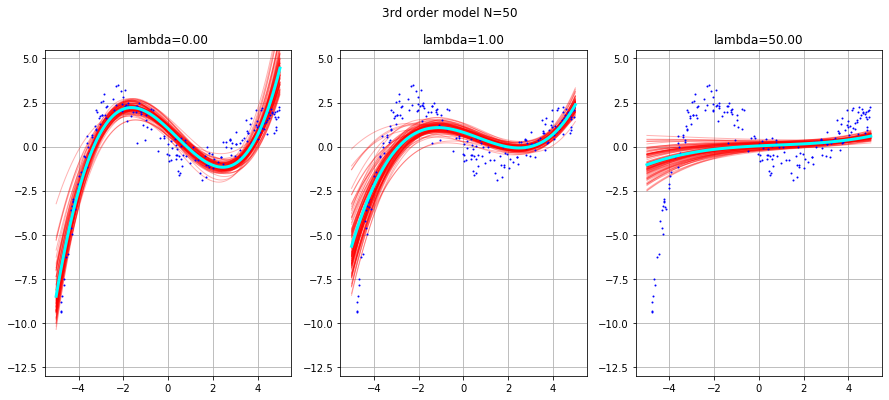

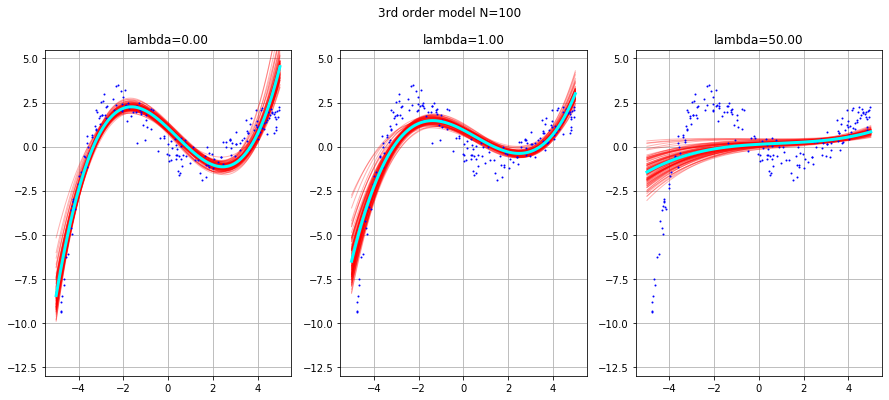

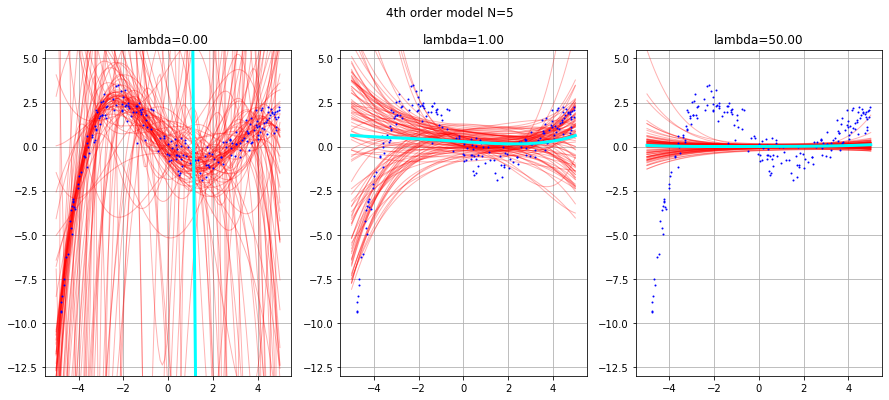

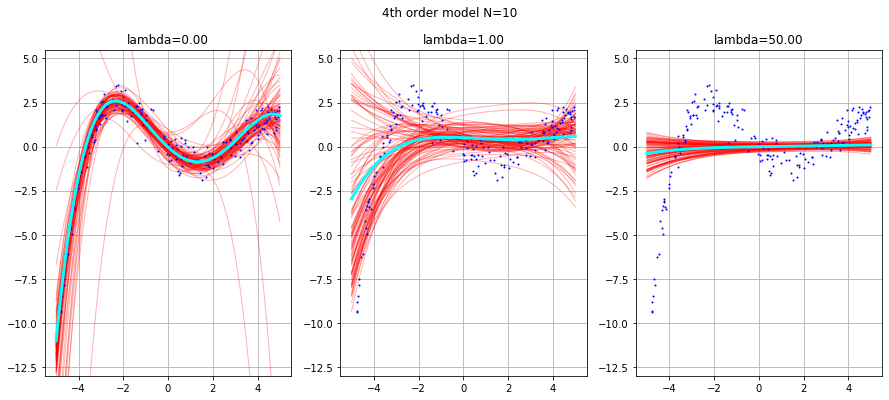

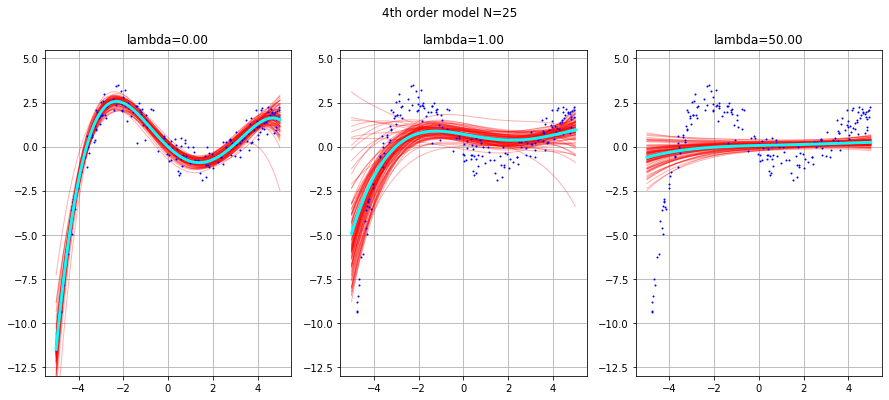

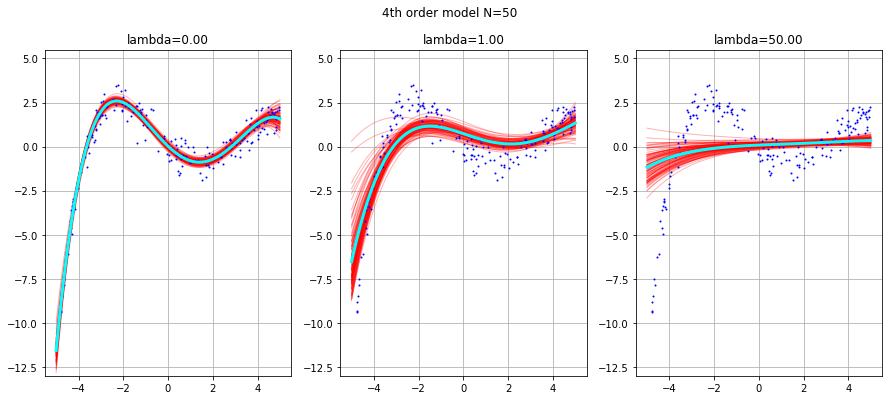

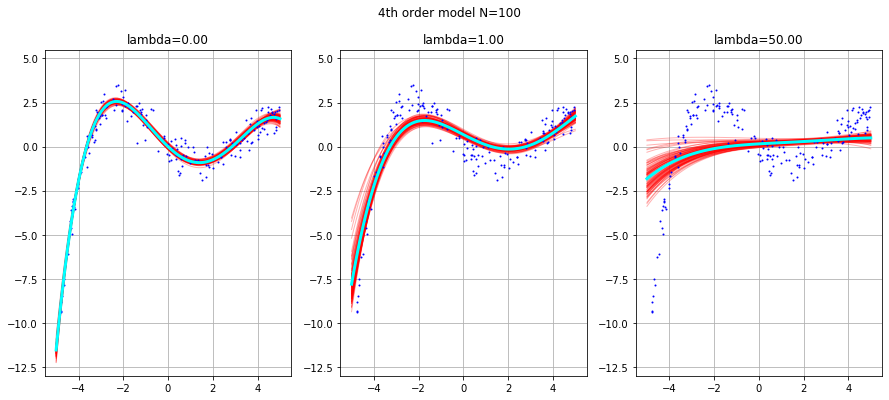

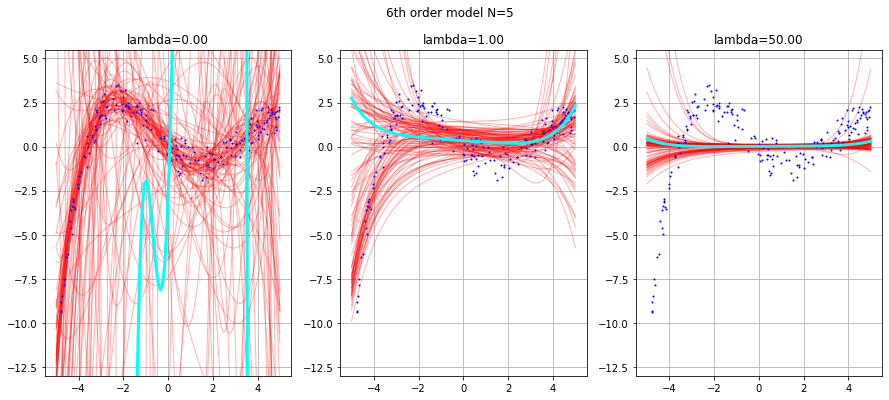

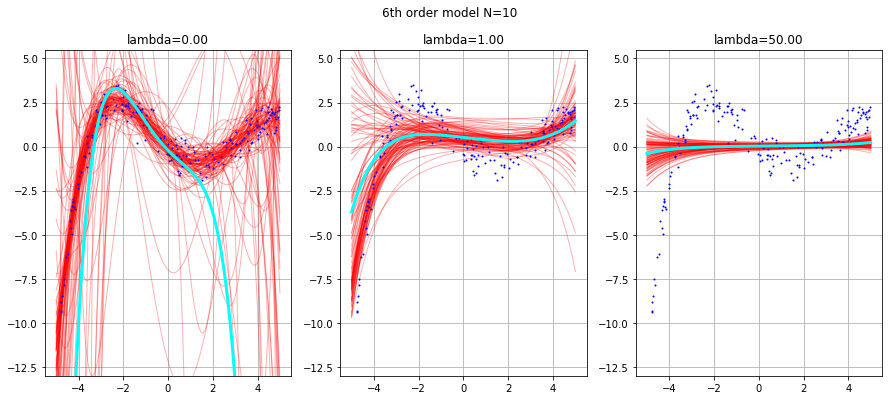

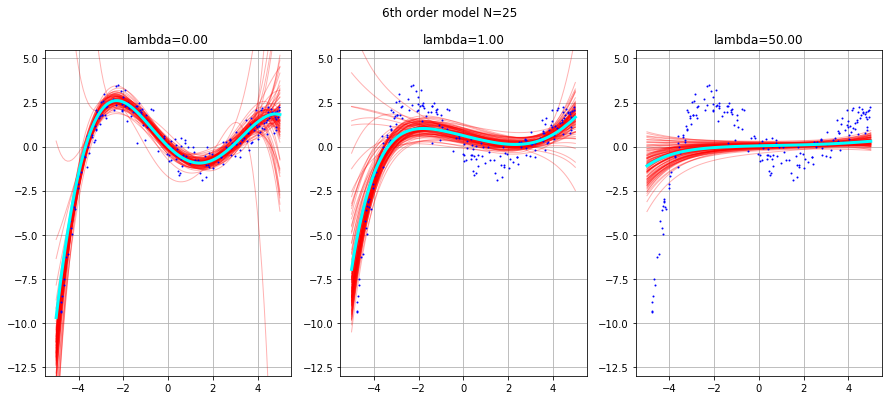

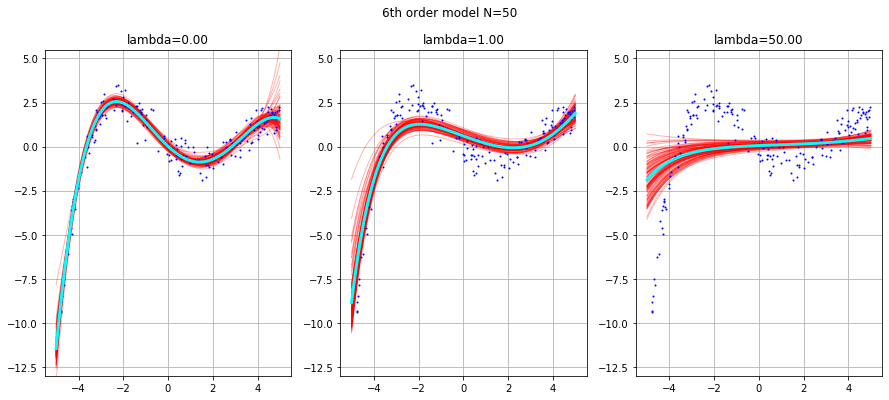

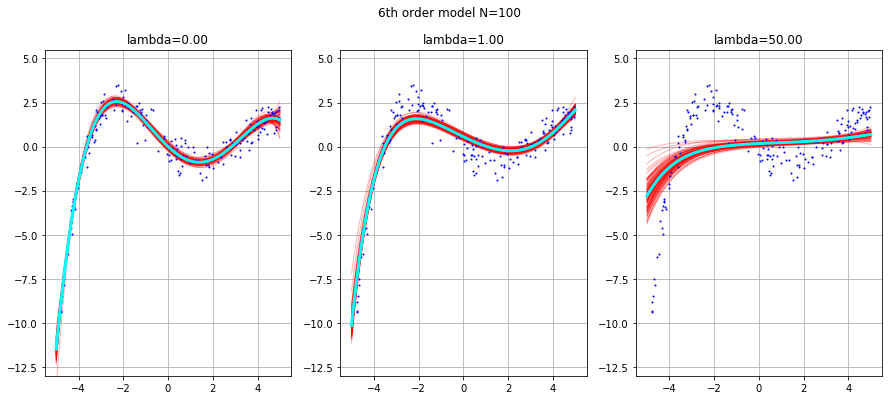

In [7]:
# we will collect all the models fit in these experiments into a dictionary
models=dict()

# this is to make plots more legible
model_names={1: "linear", 2:"quadratic", 3:"3rd order", 4:"4th order",6: "6th order"}

for deg in [1,2,3,4,6]: # for each model type
    for N in Ns: # sample 100 datasets for each N we consider
        train=gen_train_data(fn, num_samples=N, num_sets=100, domain=domain, sigma=sigma)
        # set up the figure
        fig, ax = plt.subplots(1,len(lambdas),figsize=(15,6))
        for l in range (len(lambdas)): 
            # now, for each lambda, fit 100 models of degree d with lambda as the regularization paramter
            # Each model is fit to N datapoints drawn from p(x,y)
            m_index = "N%d, d%d, l%.2f"%(N,deg,lambdas[l]) # string identifying the experiment
            models[m_index]=closed_form_reg_solution(train,lambdas[l],degree=deg) 
            # visualize the models along with a subset of points from p(x,y)
            plot(val[0,:200,:], models[m_index], domain=domain,ax=ax[l])
        fig.suptitle('%s model N=%d'%(model_names[deg],N))

# Error analysis (TO DO)

This is the part you will need to implement; see the Pset for details of what you are asked to do.

In [40]:
models['N5, d1, l0.00'][0]

{'w': array([[-0.55305526],
        [ 2.35474952]]),
 'C': array([1.        , 4.45144911]),
 'deg': 1,
 'lambda': 0}

In [47]:
xs = val[0,:,0]
xs=xs.reshape([val.shape[1],-1])
out_x,_=degexpand(xs, models['N5, d1, l0.00'][0]['deg'],C=models['N5, d1, l0.00'][0]['C'])

In [50]:
out_y=np.dot(out_x,models['N5, d1, l0.00'][0]['w'])

In [52]:
out_y.shape
ys=val[0,:,1]

In [53]:
ys.shape

(1000,)

In [119]:
squared_loss = dict()

for key in models.keys():
    loss=0
    for m in models[key]: #100models
        for i in range(val.shape[0]): #1000 validation set
            xs = val[i,:,0].reshape([val.shape[1],-1])
            ys = val[i,:,1].reshape([val.shape[1],-1])
            out_x, _ = degexpand(xs, m['deg'],C=m['C'])
            out_y = np.dot(out_x,m['w'])
            loss+=1/val.shape[0]*1/val.shape[1]*np.sum(np.square(out_y-ys))
    squared_loss[key] = loss/len(models[key])

In [121]:
squared_loss

{'N5, d1, l0.00': 10.682899853190145,
 'N5, d1, l1.00': 7.023931438249207,
 'N5, d1, l50.00': 5.599274632554679,
 'N10, d1, l0.00': 7.154931721999844,
 'N10, d1, l1.00': 6.491702627978111,
 'N10, d1, l50.00': 5.57763834218832,
 'N25, d1, l0.00': 6.028052362788693,
 'N25, d1, l1.00': 5.884016422284608,
 'N25, d1, l50.00': 5.51919684849512,
 'N50, d1, l0.00': 5.570083743406708,
 'N50, d1, l1.00': 5.527559801754788,
 'N50, d1, l50.00': 5.425654902793005,
 'N100, d1, l0.00': 5.476788238650694,
 'N100, d1, l1.00': 5.458679262260455,
 'N100, d1, l50.00': 5.35958771023246,
 'N5, d2, l0.00': 26.012292379050024,
 'N5, d2, l1.00': 6.839812999776761,
 'N5, d2, l50.00': 5.591149911987798,
 'N10, d2, l0.00': 9.521154980011177,
 'N10, d2, l1.00': 6.083975075634627,
 'N10, d2, l50.00': 5.555437676467928,
 'N25, d2, l0.00': 5.97296429640956,
 'N25, d2, l1.00': 5.472072349157612,
 'N25, d2, l50.00': 5.481733697569854,
 'N50, d2, l0.00': 4.977550352500906,
 'N50, d2, l1.00': 4.9333818012364565,
 'N50, d

In [123]:
noise =1/val.shape[0]*1/val.shape[1]*np.sum(np.square(fn(val[:,:,0])-val[:,:,1]))


In [124]:
noise

0.25028438944577613

In [141]:
variance = dict()
bias= dict()
sd = fn(val[0,:,0])
sd_matrix = np.tile(sd,(len(models[key]),1))
for key in models.keys():
    
    output_matrix = np.zeros([len(models[key]),val.shape[1]]) #100*1000
    for count,m in enumerate(models[key]): #100models
        xs = val[0,:,0].reshape([val.shape[1],-1])
        out_x, _ = degexpand(xs, m['deg'],C=m['C'])
        output_matrix[count] = np.dot(out_x,m['w']).reshape(-1) #dim 1000*1
    variance[key]=np.sum(np.var(output_matrix,axis = 0))/val.shape[1]    

    bias[key] = np.average(np.square(np.average((output_matrix-sd_matrix),axis =0)))

In [125]:
variance

{'N5, d1, l0.00': 5.5034055848115795,
 'N5, d1, l1.00': 1.7496592977238496,
 'N5, d1, l50.00': 0.017771664612090704,
 'N10, d1, l0.00': 1.8980562949262778,
 'N10, d1, l1.00': 1.2404718015869638,
 'N10, d1, l50.00': 0.02827232838973654,
 'N25, d1, l0.00': 0.7462610491452404,
 'N25, d1, l1.00': 0.626952858041249,
 'N25, d1, l50.00': 0.042962793909937305,
 'N50, d1, l0.00': 0.2588006471785585,
 'N50, d1, l1.00': 0.23942800636877237,
 'N50, d1, l50.00': 0.04012414732114651,
 'N100, d1, l0.00': 0.18150058693312324,
 'N100, d1, l1.00': 0.17432260675584058,
 'N100, d1, l50.00': 0.052158198862959276,
 'N5, d2, l0.00': 18.879457279209266,
 'N5, d2, l1.00': 1.7521297317385538,
 'N5, d2, l50.00': 0.023363099920969202,
 'N10, d2, l0.00': 4.762282618933216,
 'N10, d2, l1.00': 1.2856803496198972,
 'N10, d2, l50.00': 0.02940642210388132,
 'N25, d2, l0.00': 1.460918540799231,
 'N25, d2, l1.00': 0.8491630054381986,
 'N25, d2, l50.00': 0.045090391816108064,
 'N50, d2, l0.00': 0.460262870757381,
 'N50, d

In [142]:
bias

{'N5, d1, l0.00': 4.932184530720026,
 'N5, d1, l1.00': 5.0267205799415935,
 'N5, d1, l50.00': 5.333736190868092,
 'N10, d1, l0.00': 5.009511625268473,
 'N10, d1, l1.00': 5.00375813357744,
 'N10, d1, l50.00': 5.3016104134997555,
 'N25, d1, l0.00': 5.03444910743199,
 'N25, d1, l1.00': 5.009674609213612,
 'N25, d1, l50.00': 5.228517567172005,
 'N50, d1, l0.00': 5.063979420910498,
 'N50, d1, l1.00': 5.0408015187869895,
 'N50, d1, l50.00': 5.137871999606159,
 'N100, d1, l0.00': 5.047968795336689,
 'N100, d1, l1.00': 5.037024655350608,
 'N100, d1, l50.00': 5.059836908158656,
 'N5, d2, l0.00': 6.882531668978134,
 'N5, d2, l1.00': 4.839741849599187,
 'N5, d2, l50.00': 5.320004875241983,
 'N10, d2, l0.00': 4.509638405106903,
 'N10, d2, l1.00': 4.550041305402328,
 'N10, d2, l50.00': 5.278246230133958,
 'N25, d2, l0.00': 4.2631124237803695,
 'N25, d2, l1.00': 4.374446228887596,
 'N25, d2, l50.00': 5.1888631328255705,
 'N50, d2, l0.00': 4.268208057252845,
 'N50, d2, l1.00': 4.307274713710764,
 'N5

In [143]:
Summ = dict()
for key in variance.keys():
    Summ[key] = variance[key] + bias[key] + noise

In [144]:
Summ

{'N5, d1, l0.00': 10.685874504977381,
 'N5, d1, l1.00': 7.026664267111219,
 'N5, d1, l50.00': 5.601792244925958,
 'N10, d1, l0.00': 7.157852309640527,
 'N10, d1, l1.00': 6.494514324610179,
 'N10, d1, l50.00': 5.580167131335267,
 'N25, d1, l0.00': 6.030994546023006,
 'N25, d1, l1.00': 5.886911856700637,
 'N25, d1, l50.00': 5.521764750527718,
 'N50, d1, l0.00': 5.573064457534833,
 'N50, d1, l1.00': 5.530513914601538,
 'N50, d1, l50.00': 5.428280536373082,
 'N100, d1, l0.00': 5.479753771715588,
 'N100, d1, l1.00': 5.461631651552224,
 'N100, d1, l50.00': 5.362279496467391,
 'N5, d2, l0.00': 26.01227333763318,
 'N5, d2, l1.00': 6.842155970783516,
 'N5, d2, l50.00': 5.593652364608728,
 'N10, d2, l0.00': 9.522205413485894,
 'N10, d2, l1.00': 6.086006044468,
 'N10, d2, l50.00': 5.557937041683616,
 'N25, d2, l0.00': 5.974315354025376,
 'N25, d2, l1.00': 5.47389362377157,
 'N25, d2, l50.00': 5.484237914087454,
 'N50, d2, l0.00': 4.9787553174560015,
 'N50, d2, l1.00': 4.934906832362873,
 'N50, d2

In [145]:
diff=dict()
for key in Summ.keys():
    diff[key] = squared_loss[key] - Summ[key]

In [146]:
diff

{'N5, d1, l0.00': -0.0029746517872357714,
 'N5, d1, l1.00': -0.0027328288620118713,
 'N5, d1, l50.00': -0.002517612371279121,
 'N10, d1, l0.00': -0.0029205876406823705,
 'N10, d1, l1.00': -0.002811696632067928,
 'N10, d1, l50.00': -0.002528789146947652,
 'N25, d1, l0.00': -0.002942183234313056,
 'N25, d1, l1.00': -0.002895434416029019,
 'N25, d1, l50.00': -0.002567902032597935,
 'N50, d1, l0.00': -0.0029807141281246174,
 'N50, d1, l1.00': -0.0029541128467496236,
 'N50, d1, l50.00': -0.002625633580076503,
 'N100, d1, l0.00': -0.0029655330648941103,
 'N100, d1, l1.00': -0.0029523892917691086,
 'N100, d1, l50.00': -0.0026917862349309374,
 'N5, d2, l0.00': 1.9041416845055892e-05,
 'N5, d2, l1.00': -0.002342971006754624,
 'N5, d2, l50.00': -0.0025024526209298514,
 'N10, d2, l0.00': -0.0010504334747167832,
 'N10, d2, l1.00': -0.002030968833373059,
 'N10, d2, l50.00': -0.002499365215687277,
 'N25, d2, l0.00': -0.001351057615815776,
 'N25, d2, l1.00': -0.0018212746139578684,
 'N25, d2, l50.00'

Somehow the loss did not add up to the variance+bias+noise. But from the plot generated, when lambda is large, the variance is extremely small but the bias depends on the degree of the function(how close to the real function) and how big is the lambda. When lambda is too big, bias is huge as it cannot correcly model the data. An appropriate lambda value like 1 really reduce the variance of the matrix.

With respect of number of training data, it is clearly shown from the plot, when number of training data reaches 100, for all the function of orders >= 3, their performance is very good, both in terms of variance and bias. And when there is not enough data, such as N=5, variance is huge.

With respect to the order of the function, it is clearly shown that when the function is modeled with order < 3, lambda and training data size cannot correctly predict the label no matter what is put into modelling.

After all the observation, i think having the right modelled family, or same or more complexed than the true model family is the most important factor. Then comes with training datasize, with enough training datasize, lambda =0 can still gives very good result. At last came with the lambda value.